## ETL Pipeline for GDP Data from Archived Wikipedia

This notebook demonstrates an Extract-Transform-Load (ETL) process
that scrapes GDP (Nominal) data from an archived Wikipedia page,
cleans and transforms the data, and saves it to a CSV file.

----

Imports & Logging Setup

In [ ]:
# Import necessary libraries
import requests
import pandas as pd
import logging
from bs4 import BeautifulSoup
from datetime import datetime
from io import StringIO
import matplotlib.pyplot as plt

In [2]:
# -------------------------- #
#      Logging Setup         #
# -------------------------- #
logging.basicConfig(
    filename="etl_project_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

def log_step(message):
    """Logs and prints a step of the ETL process with a timestamp."""
    print(message)
    logging.info(message)

Helper functions

In [3]:
# Extract Function

def extract_data(url):
    """
    Extracts the GDP table from the given archived Wikipedia URL.
    """
    log_step("Starting data extraction...")
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to fetch webpage.")

    soup = BeautifulSoup(response.text, 'html.parser')
    all_tables = soup.find_all("table", {"class": "wikitable"})

    # Identify correct table by its caption
    for table in all_tables:
        caption = table.find("caption")
        if caption and "GDP (USD million) by country" in caption.text:
            log_step("Found the correct GDP table using caption.")
            df = pd.read_html(StringIO(str(table)))[0]
            return df

    raise Exception("Could not find the correct GDP table by caption.")


# Transform Function

def transform_data(df):
    """
    Cleans and transforms the extracted GDP data:
    - Keeps only Country and IMF Estimate columns
    - Removes unwanted rows/characters
    - Converts GDP to billions
    """
    log_step("Starting data transformation...")

    # Select Country and IMF Estimate columns
    df = df.iloc[:, [0, 2]]
    df.columns = ['Country', 'GDP_USD_million']

    # Remove 'World' row and invalid entries
    df = df[~df['Country'].str.lower().isin(['world', '—'])]

    # Clean GDP column: remove commas, em-dashes, footnotes
    df['GDP_USD_million'] = df['GDP_USD_million'].replace(
        to_replace=r'\[.*?\]|,|—', value='', regex=True
    )

    # Convert to numeric
    df['GDP_USD_million'] = pd.to_numeric(df['GDP_USD_million'], errors='coerce')

    # Drop NaN values
    df = df.dropna(subset=['GDP_USD_million'])

    # Convert to billions and round
    df['GDP_USD_billion'] = (df['GDP_USD_million'] / 1000).round(2)

    # Keep only final columns
    df = df[['Country', 'GDP_USD_billion']]

    log_step("Transformation complete.")
    return df


### Load Function

def load_to_csv(df, filename="Countries_by_GDP.csv"):
    """
    Saves the DataFrame to a CSV file.
    """
    log_step(f"Saving data to CSV file: {filename}")
    df.to_csv(filename, index=False)

Run the ETL Process

In [5]:

# URL of the archived Wikipedia page
url = 'https://web.archive.org/web/20230902185326/https://en.wikipedia.org/wiki/List_of_countries_by_GDP_%28nominal%29'

try:
    log_step("ETL process started.")
    
    # Extract
    df_raw = extract_data(url)
    display(df_raw.head())  # Show raw data
    
    # Transform
    df_transformed = transform_data(df_raw)
    display(df_transformed.head())  # Show transformed data
    
    # Load
    load_to_csv(df_transformed)
    
    log_step("ETL process completed successfully.")

except Exception as e:
    log_step(f"ETL process failed: {str(e)}")

ETL process started.
Starting data extraction...
Found the correct GDP table using caption.


Country/Territory UN region IMF[1][13]            World Bank[14]             \
  Country/Territory UN region   Estimate       Year       Estimate       Year   
0             World         —  105568776       2023      100562011       2022   
1     United States  Americas   26854599       2023       25462700       2022   
2             China      Asia   19373586  [n 1]2023       17963171  [n 3]2022   
3             Japan      Asia    4409738       2023        4231141       2022   
4           Germany    Europe    4308854       2023        4072192       2022   

  United Nations[15]             
            Estimate       Year  
0           96698005       2021  
1           23315081       2021  
2           17734131  [n 1]2021  
3            4940878       2021  
4            4259935       2021

Starting data transformation...
Transformation complete.


,Country,GDP_USD_billion
1,United States,26854.60
2,China,19373.59
3,Japan,4409.74
4,Germany,4308.85
5,India,3736.88


Saving data to CSV file: Countries_by_GDP.csv
ETL process completed successfully.


Plot Top 10 Countries by GDP

Creating Top 10 GDP plot...


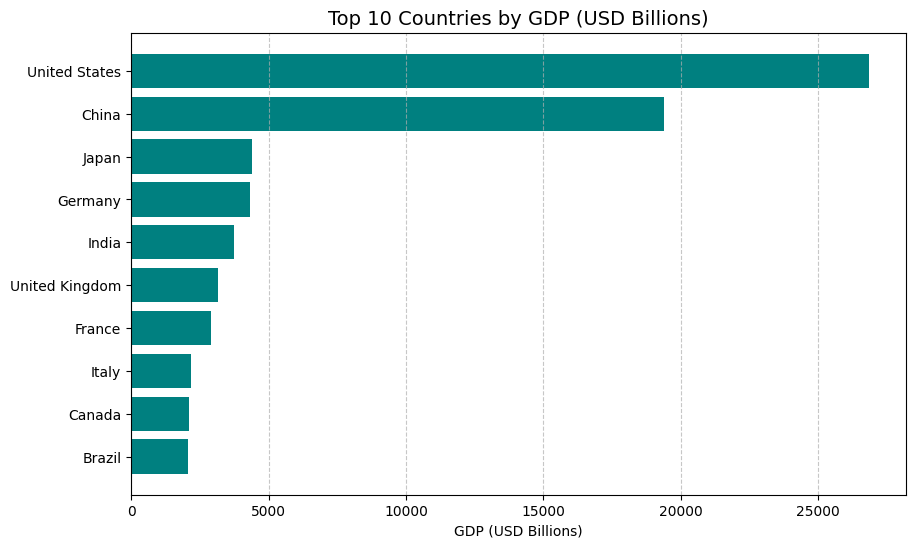

In [8]:
# Function to plot Top 10 Countries by GDP
def plot_top_10(df):
    log_step("Creating Top 10 GDP plot...")
    
    top_10 = df.sort_values(by="GDP_USD_billion", ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_10['Country'], top_10['GDP_USD_billion'], color='teal')
    plt.gca().invert_yaxis()  # Largest at the top
    plt.title("Top 10 Countries by GDP (USD Billions)", fontsize=14)
    plt.xlabel("GDP (USD Billions)")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Call the function
plot_top_10(df_transformed)
